In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


LIBRERIAS NECESARIAS

In [ ]:
import re, unicodedata
import os
import pandas as pd
import time

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk import download
from nltk.corpus import stopwords

#Libreria que permite la conexión con paginas web
import requests
from bs4 import BeautifulSoup

#Libreria para Generar la Lematización en Español
%pip install stanza
import stanza

     |████████████████████████████████| 342 kB 33.3 MB/s 


In [ ]:
download('stopwords')
download('punkt')
stanza.download('es')
nlp = stanza.Pipeline('es')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2021-08-29 23:27:29 INFO: Downloading default packages for language: es (Spanish)...


2021-08-29 23:29:21 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-08-29 23:29:21 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-08-29 23:29:21 INFO: Use device: cpu
2021-08-29 23:29:21 INFO: Loading: tokenize
2021-08-29 23:29:21 INFO: Loading: mwt
2021-08-29 23:29:21 INFO: Loading: pos
2021-08-29 23:29:21 INFO: Loading: lemma
2021-08-29 23:29:21 INFO: Loading: depparse
2021-08-29 23:29:22 INFO: Loading: ner
2021-08-29 23:29:23 INFO: Done loading processors!


FUNCIONES PARA PREPROCESAR LA DATA

In [ ]:
def limpiar_texto(texto):
    # eliminar emojis: elimina todo lo que este en <>. 
    texto_procesado = re.sub('<.*?>', ' ', texto)
    # convertir a minusculas
    texto_procesado = texto_procesado.lower()
    # remover @usuario
    #texto_procesado = re.sub('@[^\s]+',' ',texto_procesado)
    # remover urls
    texto_procesado = re.sub('rt   ',' ',texto_procesado)
    texto_procesado = re.sub('rt',' ',texto_procesado)
    texto_procesado = re.sub('rt ',' ',texto_procesado)
    # remover numeros
    texto_procesado = re.sub("\d+", "", texto_procesado)
    # texto_procesado = re.sub(r'http\S+', ' ', texto_procesado)
    texto_procesado = re.sub("(\w+:\/\/\S+)", " ", texto_procesado)
    # reemplazar todos los caracteres que no saen alfanuméricos con espacios
    texto_procesado = re.sub(r'[^a-zA-Z0-9ÑñÁáÉéÍíÓóÚú\s]', ' ', texto_procesado)
    
    return texto_procesado

def eliminar_stop_words(texto):
    # obtener lista de stopwords
    stop_words = set(stopwords.words('spanish')) 
    stop_words.remove('no')
    #separar el texto por palabras
    palabras = word_tokenize(texto) 
    # dejar solo palabras que no sean stopwords
    texto_sin_sw = [w for w in palabras if not w in stop_words] 
    #  convertir en una sola cadena la lista de palabras
    texto_sin_sw = ' '.join(texto_sin_sw)

def remove_non_ascii(word):
    """Remueve caracteres no ASCII"""
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_word

def asignar_lema(text):
  doc = nlp(text)
  new = ''
  for sent in doc.sentences:
    for word in sent.words:
      new = new + word.lemma
      new = new + ' '
      #print(f'word: {word.text} \tlemma: {word.lemma}') 
  return new

In [ ]:
def filtrar_palabras(oracion):
    a=''
    bandera = 0
    url='http://www.wordreference.com/definicion/'
    oracion = str(oracion)
    vetor_palabras = oracion.split(' ')
    for x in vetor_palabras:
      enlace=x
      buscar=url+enlace
      resp=requests.get(buscar)
      bs=BeautifulSoup(resp.text,'lxml')
      lista=bs.find_all(class_='trans clickable')
      try:
        sino=lista[0].find_all('li')
        a = a + x
        a = a + ' '
        bandera = 0
      except:
        bandera = bandera + 1
        #if(x != ''):
          #print('    --- Palabra Eliminada: ',x)
      if bandera == len(vetor_palabras):
        return 'stop'
    return a 

def eliminar_palabras_basura(a):
  filtro = filtrar_palabras(a)
  if filtro == 'stop':
    print('Esperando servidor')
    print('   -Se detuvo en: ',a)
    time.sleep(1400)
    filtro = filtrar_palabras(a)
  return filtro

In [ ]:
def PreProcesarData(Data):
  count = 0
  DataProce = Data.apply(lambda x: limpiar_texto(x))
  DataProce = DataProce.apply(lambda x: eliminar_stop_words(x))
  DataProce = DataProce.apply(lambda x: remove_non_ascii(x))
  DataProce = DataProce.apply(lambda x: eliminar_palabras_basura(x))
  DataProce = DataProce.apply(lambda x: asignar_lema(x))
  count = count + 1
  print('Se ha preprocesado: ',count,' de ',len(Data))
  return DataProce

NIVELAR DATA

In [ ]:
CORPUS = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/CORPUSPPP.xlsx').drop([0, 'Unnamed: 1'], axis=1)

#Se almacenan en variables las filas de tweets de Emergencia y de No Emergencia
Filt_Emerg = CORPUS [CORPUS['tipo'] ==  'emergencia']
Filt_NoEmerg = CORPUS [CORPUS['tipo'] !=  'emergencia']

#Se obtiene de forma aleatoria las no ermegencias, en donde la cantidad sera un poco mayor a la de no emergencias
Random_NoEmg = Filt_NoEmerg.sample((Filt_Emerg.shape[0]+70))

#Se concatena las Emergencias con las No Emergencias y se genera la nueva data
all_data = pd.concat([Filt_Emerg,Random_NoEmg]) 
NuevaCorpus = all_data.reset_index(drop = True)
NCorpusRandom = NuevaCorpus.sample(NuevaCorpus.shape[0]).reset_index(drop = True)

#Se guarda la data resultante
NCorpusRandom.to_excel('NuevaCorpusCorregida.xlsx')
!cp NuevaCorpusCorregida.xlsx '/content/gdrive/My Drive/Colab Notebooks/'

PRE PROCESAR DATA

In [ ]:
#Carga la Data Original, se eliminan aquellos campos que no se necesitan
Corpus = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/NuevaCorpusCorregida.xlsx')
Corpus = Corpus.drop(['Unnamed: 0','place_name', 'created_at', 'categoría', 'nivel 2', 'servicio'], axis=1)

In [ ]:
TextData = PreProcesarData(Corpus['text'])
TipoData = Corpus['tipo'].replace(['emergencia'], 1).replace(['no emergencia'], 0)
Corpus['text'] = TextData
Corpus['tipo'] = TipoData

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [ ]:
#ALMACENAR NUEVA DATA
Corpus.to_excel('4DataFinalLemaFiltro.xlsx', index=False)
!cp 4DataFinalLemaFiltro.xlsx '/content/gdrive/My Drive/Colab Notebooks/Reporte_tweets_Ecuador/'

PRUEBA DE ESCRITORIO

In [ ]:
#Ejemplo que muestra el resultado del preprocesamiento
Info = [['emergencia','hola mundo esto es una prueba'],['no emergencia','La vida es muy interesante #vivir asdsd :) 12']]
Info = pd.DataFrame(Info, columns=['tipo','text'])
Info

,tipo,text
0,emergencia,hola mundo esto es una prueba
1,no emergencia,La vida es muy interesante #vivir asdsd :) 12


In [ ]:
txt = PreProcesarData(Info['text'])
tipo = Info['tipo'].replace(['emergencia'], 1).replace(['no emergencia'], 0)
Info['text'] = txt
Info['tipo'] = tipo
Info

,tipo,text
0,1,holar mundo probar
1,0,vida interesante vivir asdsd


REVISIÓN

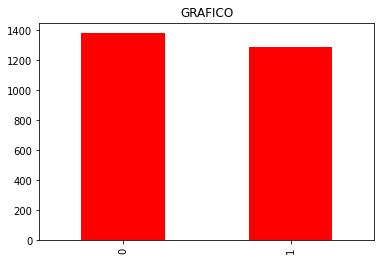

In [4]:
import pandas as pd
Data_Resultante = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Reporte_tweets_Ecuador/4DataFinalLemaFiltro.xlsx')

%matplotlib inline

Data_Resultante['tipo'].value_counts().plot(kind='bar', color="red", title="GRAFICO")

In [6]:
Data_Resultante['tipo'].value_counts()

0    1380
1    1290
Name: tipo, dtype: int64